In [0]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
device_name = tf.test.gpu_device_name()

In [0]:
device_name

'/device:GPU:0'

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp '/content/gdrive/My Drive/ColabTrain/Data/data3.zip' 'data.zip'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [0]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
%ldir

drwx------ 4 root     4096 Oct 30 10:09 gdrive/
drwxr-xr-x 1 root     4096 Oct 25 16:58 sample_data/


In [0]:
!unzip data.zip

Archive:  data.zip
   creating: train/
   creating: train/V/
  inflating: train/V/0.jpg           
  inflating: train/V/2.jpg           
  inflating: train/V/26.jpg          
  inflating: train/V/27.jpg          
  inflating: train/V/29.jpg          
  inflating: train/V/37.jpg          
  inflating: train/V/42.jpg          
  inflating: train/V/44.jpg          
  inflating: train/V/47.jpg          
  inflating: train/V/50.jpg          
  inflating: train/V/75.jpg          
  inflating: train/V/79.jpg          
  inflating: train/V/84.jpg          
  inflating: train/V/105.jpg         
  inflating: train/V/122.jpg         
  inflating: train/V/130.jpg         
  inflating: train/V/135.jpg         
  inflating: train/V/145.jpg         
  inflating: train/V/167.jpg         
  inflating: train/V/177.jpg         
  inflating: train/V/198.jpg         
  inflating: train/V/209.jpg         
  inflating: train/V/212.jpg         
  inflating: train/V/217.jpg         
  inflating: train/V/234.jp

In [0]:
train_data = 'train'
test_data = 'validation'

In [0]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_image_data = train_image_generator.flow_from_directory(train_data, target_size=IMAGE_SHAPE)
test_image_data = test_image_generator.flow_from_directory(test_data, target_size=IMAGE_SHAPE)

Found 1866 images belonging to 10 classes.
Found 640 images belonging to 10 classes.


In [0]:
for image_batch, label_batch in train_image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 10)


In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [0]:
feature_batch = feature_extractor_layer(image_batch)
feature_batch.shape

TensorShape([Dimension(32), Dimension(1280)])

In [0]:
feature_extractor_layer.trainable = False

In [0]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(train_image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
%ldir

drwx------  4 root     4096 Oct 30 10:09 gdrive/
drwxr-xr-x  1 root     4096 Oct 25 16:58 sample_data/
drwxr-xr-x 12 root     4096 Oct 30 09:52 train/
drwxr-xr-x 12 root     4096 Oct 30 10:07 validation/


In [0]:
full_path = 'gdrive/My Drive/ColabTrain/'

In [0]:
# checkpoint
filepath= full_path + "checkpoints/check_v1.0-{epoch:02d}-{acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, target='max')

In [0]:
EPOCHS = 25
steps_per_epoch = np.ceil(train_image_data.samples/train_image_data.batch_size)
validation_steps = np.ceil(test_image_data.samples/test_image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(train_image_data,
                              validation_data=test_image_data,
                              validation_steps=validation_steps,
                              epochs=EPOCHS,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback, checkpoint])

Epoch 1/25
20/59 [=========>....................] - ETA: 3s - loss: 0.6615 - acc: 0.7969
Epoch 00001: val_acc did not improve from 0.80156
59/59 [==============================] - 7s 116ms/step - loss: 0.0797 - acc: 1.0000 - val_loss: 0.6615 - val_acc: 0.7969
Epoch 2/25
20/59 [=========>....................] - ETA: 3s - loss: 0.6422 - acc: 0.7937
Epoch 00002: val_acc did not improve from 0.80156
59/59 [==============================] - 7s 112ms/step - loss: 0.0727 - acc: 1.0000 - val_loss: 0.6422 - val_acc: 0.7937
Epoch 3/25
20/59 [=========>....................] - ETA: 3s - loss: 0.6649 - acc: 0.7797
Epoch 00003: val_acc did not improve from 0.80156
59/59 [==============================] - 7s 113ms/step - loss: 0.0681 - acc: 1.0000 - val_loss: 0.6649 - val_acc: 0.7797
Epoch 4/25
20/59 [=========>....................] - ETA: 3s - loss: 0.6446 - acc: 0.8016
Epoch 00004: val_acc did not improve from 0.80156
59/59 [==============================] - 7s 111ms/step - loss: 0.0658 - acc: 1.00

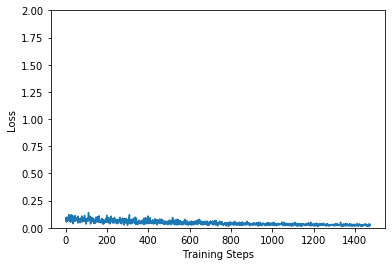

In [0]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

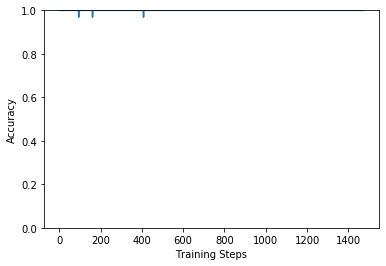

In [0]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

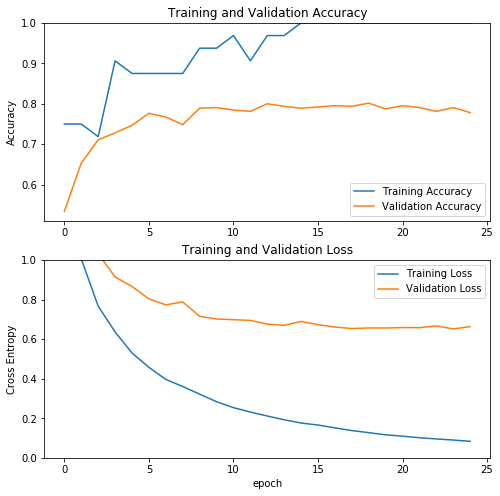

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
model.save(full_path + 'saved_models/' + 'validated_25e_v2.h5')

In [0]:
tf.saved_model.save(model, full_path + 'saved_models/' + 'validated_10e_v1/')

FailedPreconditionError: ignored

In [0]:
model.save(full_path + 'saved_models/' + 'validated_5e_v1.h5', save_format='tf')

In [0]:
class_names = sorted(test_image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['A', 'B', 'C', 'D', 'G', 'H', 'I', 'L', 'V', 'Y'], dtype='<U1')

In [0]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [0]:
label_id = np.argmax(label_batch, axis=-1)

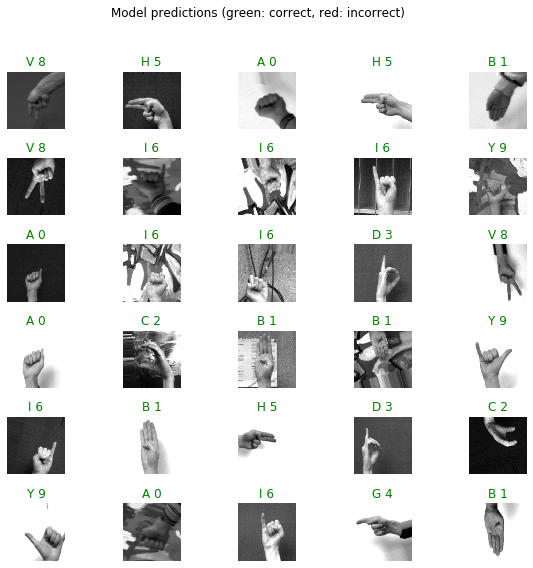

In [0]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title() + ' ' + str(predicted_id[n]), color=color)
    plt.axis('off')
    _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [0]:
reloaded = tf.keras.models.load_model(full_path + 'checkpoints/weights-improvement-03-0.91.hdf5')